In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'
load_wilcoxon = True
load_gsea = True
load_gsea_heatmap = False
run_umap = False

# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Labels that com from each study to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [2]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [3]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 32073 × 36896
    obs: 'sample', 'gsm', 'tissue', 'sex', 'age', 'characteristics_ch1.7.treatment received prior to surgery (1= treated; 0=untreated)', 'patient', 'condition', 'origin', 'platform', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Types from infercnv dir

In [4]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types = types.rename(columns={'Unnamed: 0':'barcode_'})
types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
types

,barcode_,cell_type
0,bcEAPU_0,Lymphoid
1,bcFTPA_0,Airway epithelium
2,bcEBDX_0,Alveolar epithelium
3,bcFPHC_0,Airway epithelium
4,bcCLVG_0,Fibroblast lineage
...,...,...
32068,bcBOGU_25,Lymphoid
32069,bcHDOT_25,Airway epithelium
32070,bcIFTF_25,Lymphoid
32071,bcBDLT_25,Lymphoid


In [5]:
adata.obs['barcode_'] = adata.obs.index
adata.obs = pd.merge(adata.obs, types, on='barcode_',
                    how='left')
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

Index(['sample', 'gsm', 'tissue', 'sex', 'age',
       'characteristics_ch1.7.treatment received prior to surgery (1= treated; 0=untreated)',
       'patient', 'condition', 'origin', 'platform', 'n_counts', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'barcode_', 'cell_type'],
      dtype='object')

### Tumor prediction from ikarus

In [6]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
preds

,Unnamed: 0,final_pred
0,0,Normal
1,1,Normal
2,2,Normal
3,3,Normal
4,4,Normal
...,...,...
32068,32068,Normal
32069,32069,Normal
32070,32070,Normal
32071,32071,Normal


In [7]:
adata.obs['final_pred'] = list(preds.iloc[:,1])

In [8]:
adata.obs['origin']

0        tumor_primary
1        tumor_primary
2        tumor_primary
3        tumor_primary
4        tumor_primary
             ...      
32068    tumor_primary
32069    tumor_primary
32070    tumor_primary
32071    tumor_primary
32072    tumor_primary
Name: origin, Length: 32073, dtype: category
Categories (1, object): ['tumor_primary']

In [9]:
adata[np.logical_or(adata.obs['origin'].str.contains('normal'), adata.obs['origin']=='tumor_primary')].obs['origin'].value_counts()

origin
tumor_primary    32073
Name: count, dtype: int64

In [10]:
adata.layers['counts'] = adata.X

In [11]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [12]:
#papermill_description=UMAP
if run_umap:
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

In [13]:
if run_umap:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    sc.pl.umap(
        adata,
        color="cell_type",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="final_pred",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="origin",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="sample",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    # Display the entire figure with all plots
    plt.tight_layout()
    plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [14]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_26886/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
p1t1    2033
p1t2    2253
p1t3    1182
p1t4    1332
p2t1     200
p2t2     166
p3t1    2682
p3t2    2874
p3t3    2711
p4t1    1366
p4t2    1255
p4t3    1547
p5t1    1108
p5t2    2034
p6t1    2471
p6t2    2195
p7t1    2461
p7t2    2203
Name: gsm, dtype: int64

## Marker Genes

Create a column that merges cell type, tissue and tumor pred

In [15]:
adata.obs['type_tissue'] = adata.obs.apply(lambda x: str(x['cell_type']) + '_' + 
                 ('HT' if 'normal' in x['origin'] else 'TT') + 
                 '_' + x['final_pred'], axis=1)
adata.obs['type_tissue'] = adata.obs['type_tissue'].astype('category')
adata.obs['type_tissue']

0                   Lymphoid_TT_Normal
1          Airway epithelium_TT_Normal
2        Alveolar epithelium_TT_Normal
3          Airway epithelium_TT_Normal
4         Fibroblast lineage_TT_Normal
                     ...              
32068               Lymphoid_TT_Normal
32069      Airway epithelium_TT_Normal
32070               Lymphoid_TT_Normal
32071               Lymphoid_TT_Normal
32072                Myeloid_TT_Normal
Name: type_tissue, Length: 32073, dtype: category
Categories (16, object): ['Airway epithelium_TT_Normal', 'Airway epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal', 'Alveolar epithelium_TT_Tumor', ..., 'Smooth muscle_TT_Normal', 'Submucosal Gland_TT_Normal', 'Unknown_TT_Normal', 'Unknown_TT_Tumor']

In [16]:
# We dont get them with unique because it saves the NaN's
adata.obs.cell_type = adata.obs.cell_type.astype('category')
types = adata.obs.cell_type.cat.categories
num_types = len(types)
types

Index(['Airway epithelium', 'Alveolar epithelium', 'Blood vessels',
       'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid', 'Myeloid',
       'Smooth muscle', 'Submucosal Gland', 'Unknown'],
      dtype='object')

In [17]:
adata.obs['type_tissue'].value_counts()

type_tissue
Lymphoid_TT_Normal               17084
Myeloid_TT_Normal                10101
Airway epithelium_TT_Tumor        1256
Alveolar epithelium_TT_Normal      946
Unknown_TT_Normal                  773
Fibroblast lineage_TT_Normal       619
Airway epithelium_TT_Normal        618
Blood vessels_TT_Normal            359
Unknown_TT_Tumor                   195
Smooth muscle_TT_Normal             65
Lymphoid_TT_Tumor                   31
Lymphatic EC_TT_Normal              11
Myeloid_TT_Tumor                    10
Alveolar epithelium_TT_Tumor         2
Blood vessels_TT_Tumor               2
Submucosal Gland_TT_Normal           1
Name: count, dtype: int64

In [18]:
#papermill_description=WILCOXON_DE
# Get the groups that have more than 2 cells associated with them
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/all_{id_}.npy'
key = "wilcoxon"

if load_wilcoxon:
    adata.uns[key] = np.load(all_path, allow_pickle='TRUE').item()
else:
    sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = key,
                       groups=valid_types)
    np.save(all_path, adata.uns[key])

for type in types:
    tumor_tumor = type + '_TT_Tumor'
    normal_tumor = type + '_TT_Normal'
    normal_healthy = type + '_HT_Normal'

    differ_key = f"w_pair_{type}_differ"
    normal_key = f"w_pair_{type}_normal"
    differ_path =  f'{w_folder}/{differ_key}.npy'
    normal_path = f'{w_folder}/{normal_key}.npy'
    if load_wilcoxon:
        # We check for existance  here and not up there because there some datasets with no normal tissue
        if os.path.exists(differ_path):
            adata.uns[differ_key] = np.load(differ_path, allow_pickle='TRUE').item()
        if os.path.exists(normal_path):
            adata.uns[normal_key] = np.load(normal_path, allow_pickle='TRUE').item()
    else:
        if set([tumor_tumor, normal_tumor]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = differ_key,
                                    groups=[tumor_tumor], reference=normal_tumor)
            np.save(differ_path, adata.uns[differ_key])
            
        if set([normal_tumor, normal_healthy]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = normal_key,
                                    groups=[normal_tumor], reference=normal_healthy)
            np.save(normal_path, adata.uns[normal_key])

In [19]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    print(cond_types)
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

In [20]:
valid_types

['Lymphoid_TT_Normal',
 'Myeloid_TT_Normal',
 'Airway epithelium_TT_Tumor',
 'Alveolar epithelium_TT_Normal',
 'Unknown_TT_Normal',
 'Fibroblast lineage_TT_Normal',
 'Airway epithelium_TT_Normal',
 'Blood vessels_TT_Normal',
 'Unknown_TT_Tumor',
 'Smooth muscle_TT_Normal',
 'Lymphoid_TT_Tumor',
 'Lymphatic EC_TT_Normal',
 'Myeloid_TT_Tumor']

['Airway epithelium_TT_Tumor']
['Airway epithelium_TT_Tumor', 'Airway epithelium_TT_Normal']
['Alveolar epithelium_TT_Tumor']
['Alveolar epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal']
['Blood vessels_TT_Tumor']
['Blood vessels_TT_Tumor', 'Blood vessels_TT_Normal']
['Fibroblast lineage_TT_Tumor']
['Fibroblast lineage_TT_Tumor', 'Fibroblast lineage_TT_Normal']
['Lymphatic EC_TT_Tumor']
['Lymphatic EC_TT_Tumor', 'Lymphatic EC_TT_Normal']
['Lymphoid_TT_Tumor']
['Lymphoid_TT_Tumor', 'Lymphoid_TT_Normal']
['Myeloid_TT_Tumor']
['Myeloid_TT_Tumor', 'Myeloid_TT_Normal']
['Smooth muscle_TT_Tumor']
['Smooth muscle_TT_Tumor', 'Smooth muscle_TT_Normal']
['Submucosal Gland_TT_Tumor']
['Submucosal Gland_TT_Tumor', 'Submucosal Gland_TT_Normal']
['Unknown_TT_Tumor']
['Unknown_TT_Tumor', 'Unknown_TT_Normal']


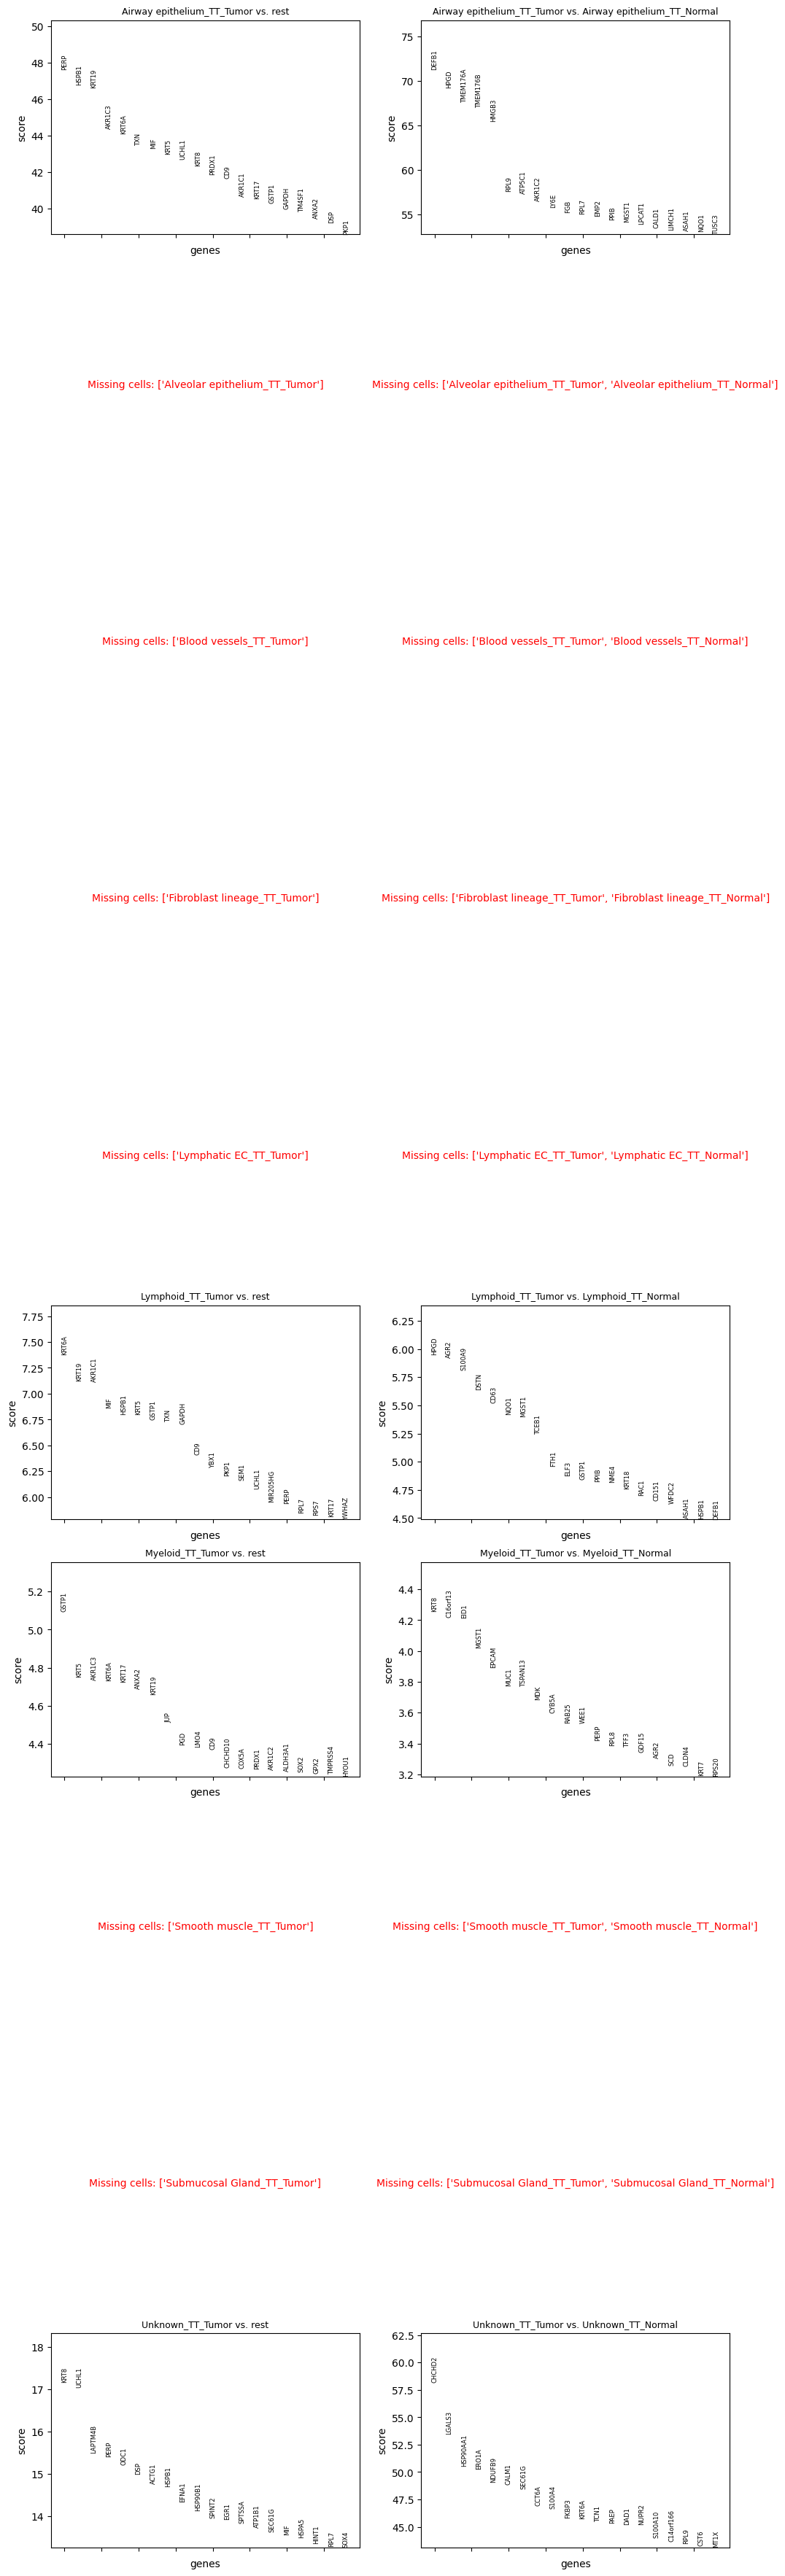

In [21]:
if(adata.obs.origin.str.contains('tumor').any()):
    fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        tumor_tumor = type + '_TT_Tumor'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [tumor_tumor], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
                                key=f"w_pair_{type}_differ", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    from warnings import warn
    warn('NO TUMOR TISSUES!?!?!?!!?')

In [22]:
adata.obs.origin.str.contains('normal').any()

False

In [23]:
from warnings import warn

if(adata.obs.origin.str.contains('normal').any()):
    fig, axs = plt.subplots(num_types, 3, figsize=(17, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        normal_healthy = type + '_HT_Normal'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [normal_healthy], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [normal_tumor], valid_types, n_genes=n_genes,
                                ax= axs[i, 1], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        print(f"w_pair_{type}_normal")
        cond_plot(adata, [normal_tumor, normal_healthy], valid_types, n_genes=n_genes, ax= axs[i, 2],
                                key=f"w_pair_{type}_normal", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    warn('No healthy tissue!')
    

/tmp/ipykernel_26886/3062282855.py:27: UserWarning: No healthy tissue!
  warn('No healthy tissue!')


## Heatmaps

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_TT_Normal, Airway epithelium_TT_Tumor, Alveolar epithelium_TT_Normal, etc.
var_group_labels: Lymphoid_TT_Normal, Myeloid_TT_Normal, Airway epithelium_TT_Tumor, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


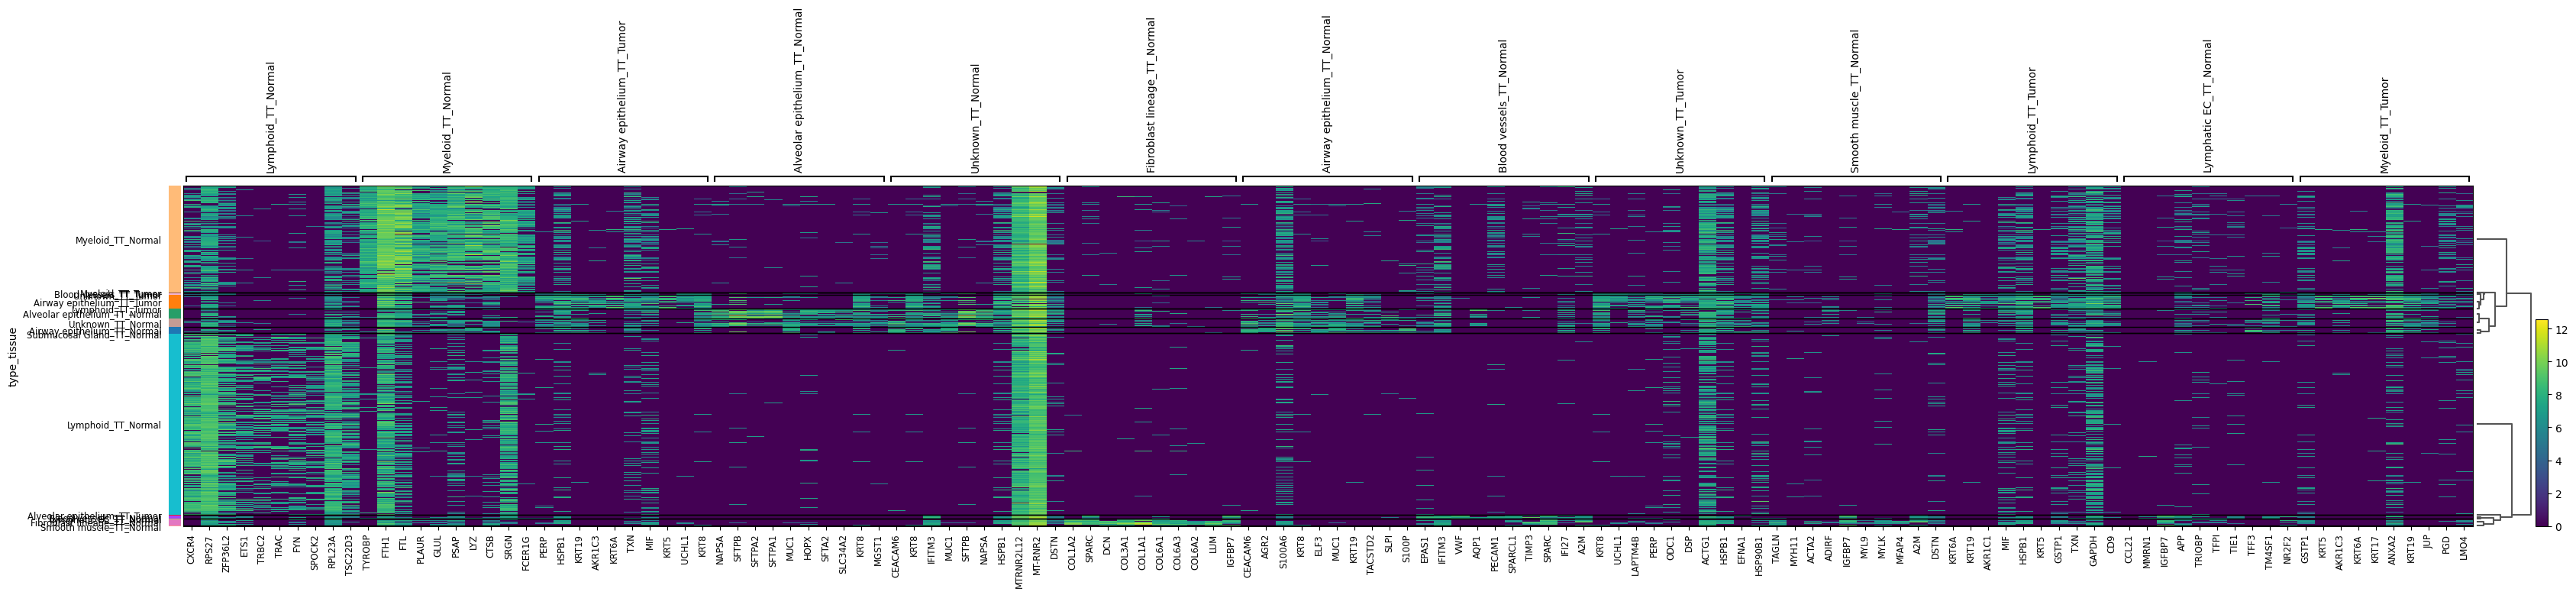

In [24]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [25]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [26]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [27]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [28]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

In [29]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str], types: List[str], id_: str, load_gsea: bool = False) -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)

    gsea_folder = 'gseapy_gsea'
    dfs = []

    for type in types:
        wilco = adata.uns['wilcoxon']
        gsea_path = f'{gsea_folder}/{type}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: wilco['scores'][type][i] for i, gene in enumerate(wilco['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [55]:
#papermill_description=GSEA
gsea_folder = 'gseapy_gsea'
gsea_path = f'{gsea_folder}/heatmap_{id_}.csv'

if load_gsea_heatmap:
    combined_df = pd.read_csv(gsea_path, index_col=0)
else:
    types = adata.obs.loc[:, 'type_tissue'].unique()
    combined_df = get_gseas_df(adata, valid_types, types, id_, load_gsea=False)
    combined_df.to_csv(gsea_path)

In [56]:
combined_df

,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
cell_type,,,,,,,,,,,,,,,,,,,,,
Airway epithelium_TT_Normal,1.167997,-2.023808,1.257028,0.937519,1.224756,0.982486,1.216021,1.123707,1.371945,1.188322,...,1.405705,1.097269,1.009018,1.237377,0.905983,1.168256,1.094434,1.127213,0.846990,1.207717
Airway epithelium_TT_Tumor,1.174550,-1.000000,1.190144,0.887853,1.061850,0.916379,1.062419,1.051029,1.191951,0.866518,...,1.264067,1.277804,1.107312,1.119263,0.819703,1.324653,1.015440,1.145639,1.102151,1.191500
Alveolar epithelium_TT_Normal,1.224103,-1.000000,1.185689,0.867335,1.052209,0.885574,1.199965,1.134807,1.256365,1.176461,...,1.275539,1.214698,1.029595,1.098235,0.872274,1.335699,1.121837,1.184984,1.028175,1.227201
Blood vessels_TT_Normal,1.185751,-1.616873,0.884362,1.289462,1.452071,1.072825,1.231193,-1.236882,-1.059719,1.555001,...,0.890414,0.866658,0.819246,1.613278,-1.112149,-1.265341,1.521092,1.099783,1.265308,1.033728
Fibroblast lineage_TT_Normal,1.076586,-1.797882,0.995434,1.470615,1.397029,1.018995,1.308749,0.851583,0.838934,1.569810,...,1.305308,1.018911,0.693705,1.374985,0.861024,1.074273,1.550210,0.921561,1.269677,1.213376
Lymphatic EC_TT_Normal,1.056032,-1.439660,0.936845,1.165867,1.283691,1.347165,1.103913,1.001106,-1.031067,1.559468,...,0.918450,-0.912567,0.873606,1.240495,-1.441205,-1.004253,1.344273,-1.098217,0.961193,-1.160600
Lymphoid_TT_Normal,-1.268474,-0.959829,-1.242833,-1.168183,-1.178471,-0.971370,-1.210729,-1.101979,-1.238741,-1.251050,...,-1.344936,-1.319393,-0.957374,-1.287500,-1.259916,-1.234266,-1.064568,-1.199534,-0.974758,-1.216413
Lymphoid_TT_Tumor,1.209289,0.698877,1.194974,0.768441,1.066047,0.991637,1.066657,1.012321,1.121493,0.772369,...,1.288784,1.278511,0.985625,1.210140,0.798888,1.274980,1.030107,1.122973,1.075410,1.125684
Myeloid_TT_Normal,1.252532,1.142610,1.180434,1.188045,1.169424,1.034885,1.221929,1.156396,1.217899,1.268201,...,1.245811,1.202173,0.903791,1.246436,1.346186,1.191221,0.915525,1.228155,0.973181,1.198922


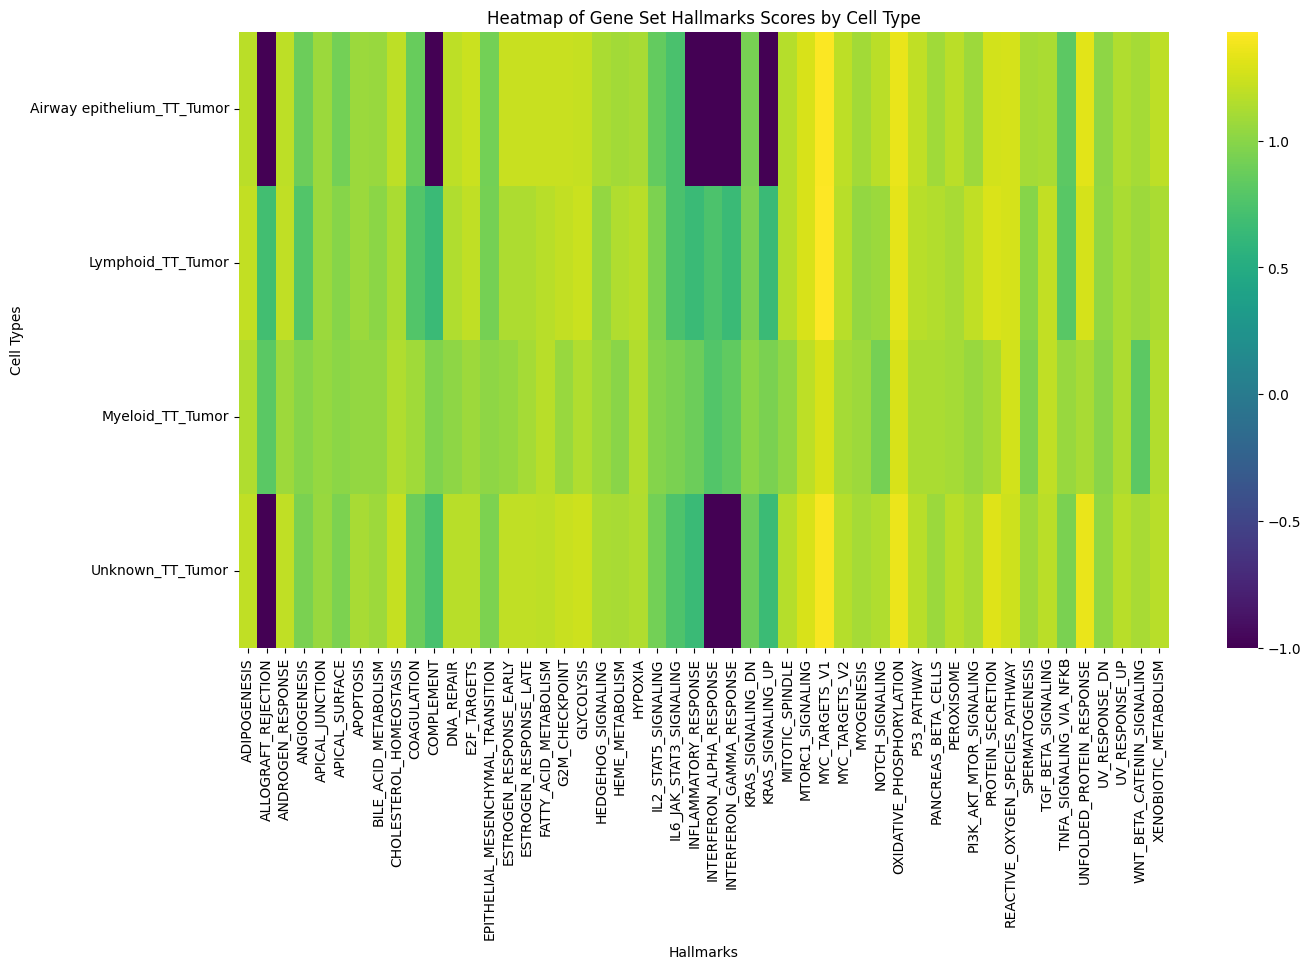

In [58]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Tumor']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df_tumor, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()

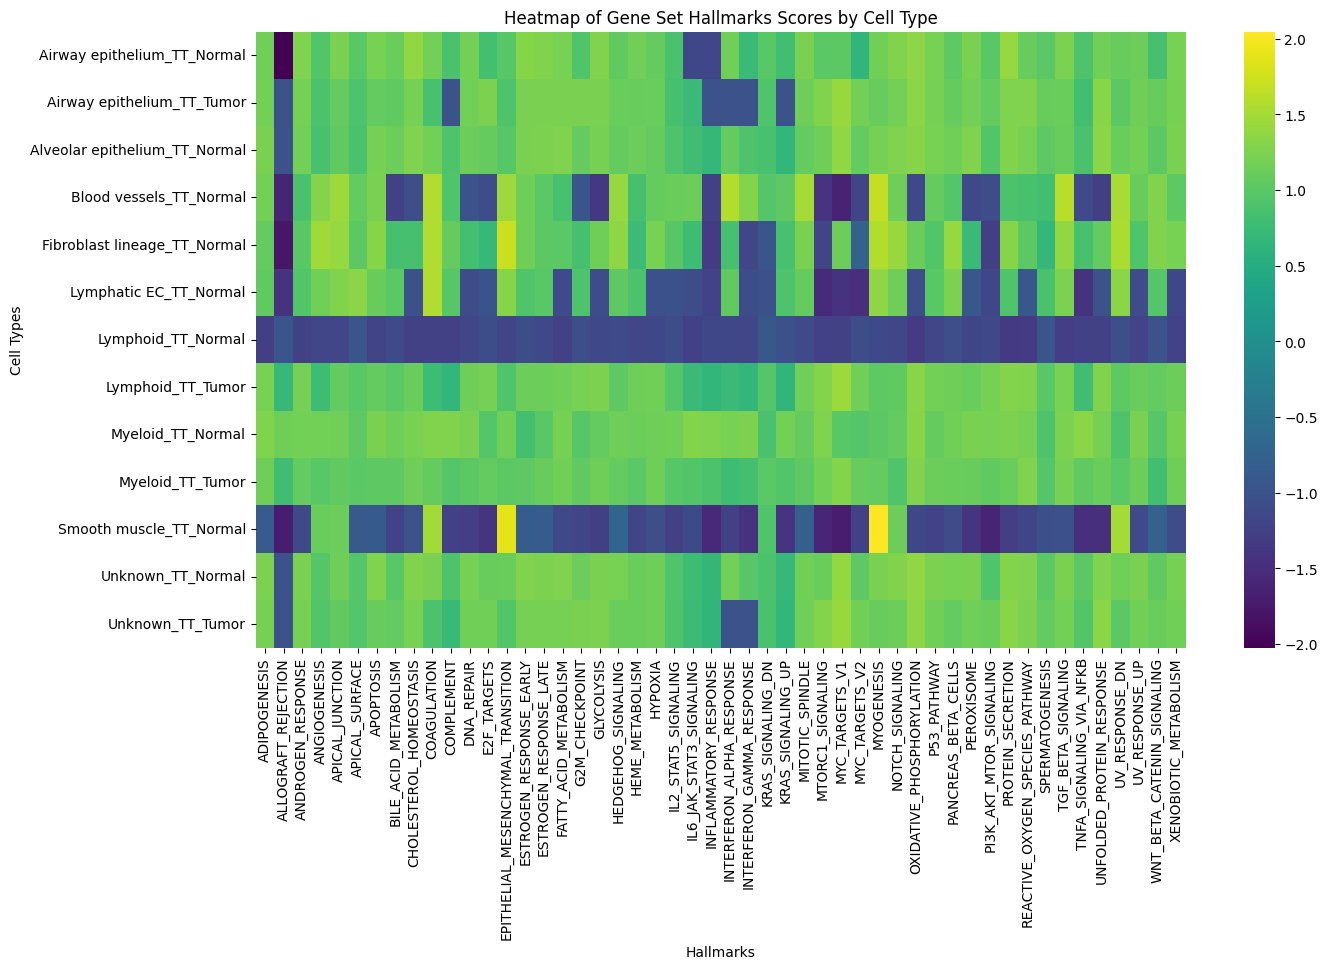

In [59]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Normal']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()